In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import numpy as np

def export_tensorboard_data(log_dir, output_file):
    """Export TensorBoard scalars to CSV"""
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get available scalar tags
    scalar_tags = event_acc.Tags()['scalars']
    
    data = {}
    for tag in scalar_tags:
        scalar_events = event_acc.Scalars(tag)
        steps = [event.step for event in scalar_events]
        values = [event.value for event in scalar_events]
        data[f'{tag}_step'] = steps
        data[f'{tag}_value'] = values
    
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    return df

In [6]:
import os
import glob
import numpy as np
import nibabel as nib
from monai.transforms import CropForegroundd
from tqdm import tqdm

# --- Configuration ---
INPUT_BASE_DIR = "/data/hjlee/orhun/data/BRATS21/Training"
OUTPUT_BASE_DIR = "/data/hjlee/orhun/data/BRATS21_Processed/Training"
OUTPUT_IMAGES_DIR = os.path.join(OUTPUT_BASE_DIR, "Images")
OUTPUT_LABELS_DIR = os.path.join(OUTPUT_BASE_DIR, "Labels")

def process_brats_dataset():
    """
    Processes the BraTS dataset by combining MRI modalities, applying foreground cropping,
    and saving the results to a new directory structure.
    """
    # Create output directories if they don't exist
    os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
    os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)
    print(f"Output images will be saved to: {OUTPUT_IMAGES_DIR}")
    print(f"Output labels will be saved to: {OUTPUT_LABELS_DIR}")

    # Get all patient directories (e.g., "BraTS-GLI-00000-000")
    patient_dirs = sorted([d for d in glob.glob(os.path.join(INPUT_BASE_DIR, "BraTS-*-*")) if os.path.isdir(d)])

    if not patient_dirs:
        print(f"Error: No patient directories found in {INPUT_BASE_DIR}. Please check the path.")
        return

    # Initialize the MONAI transform for cropping.
    # The crop is based on the label (segmentation mask) to isolate the tumor region.
    cropper = CropForegroundd(keys=['image', 'label'], source_key='image', margin=0)

    for p_dir in tqdm(patient_dirs, desc="Processing Patients"):
        patient_id = os.path.basename(p_dir)
        
        # Find all nifti files for the patient
        nii_files = glob.glob(os.path.join(p_dir, "*.nii.gz"))
        
        label_path = None
        image_paths = []
        
        for f in nii_files:
            if "seg" in os.path.basename(f):
                label_path = f
            else:
                # Collect all other .nii.gz files as image modalities
                image_paths.append(f)
        
        # Sort image paths to ensure a consistent channel order (e.g., t1c, t1n, t2f, t2w)
        image_paths.sort()
        
        if not label_path or not image_paths:
            print(f"Warning: Skipping {patient_id} due to missing image or label files.")
            continue
            
        try:
            # --- 1. Load and Concatenate Images (without MONAI) ---
            
            # Load the label to get its data and affine matrix
            label_nii = nib.load(label_path)
            label_data = label_nii.get_fdata().astype(np.uint8)
            
            # Load all image modalities
            image_data_list = [nib.load(p).get_fdata() for p in image_paths]
            
            # Stack modalities along a new last axis to get (H, W, D, C)
            combined_image_data = np.stack(image_data_list, axis=-1)
            
            # --- 2. Prepare for MONAI Transform ---
            
            # MONAI expects channel-first data: (C, H, W, D). We transpose our combined image.
            combined_image_monai = np.transpose(combined_image_data, (3, 0, 1, 2))
            
            # The label also needs a channel dimension: (H, W, D) -> (1, H, W, D)
            label_monai = np.expand_dims(label_data, axis=0)
            
            # Create the dictionary that MONAI's transform will operate on
            data_dict = {'image': combined_image_monai, 'label': label_monai}
            
            # --- 3. Apply Foreground Cropping (with MONAI) ---
            cropped_dict = cropper(data_dict)
            
            cropped_image_monai = cropped_dict['image']
            cropped_label_monai = cropped_dict['label']
            
            # --- 4. Prepare for Saving (without MONAI) ---
            
            # Transpose the cropped image back to channel-last for saving: (C, H, W, D) -> (H, W, D, C)
            cropped_image_to_save = np.transpose(cropped_image_monai, (1, 2, 3, 0))
            
            # Remove the channel dimension from the label: (1, H, W, D) -> (H, W, D)
            cropped_label_to_save = np.squeeze(cropped_label_monai, axis=0)
            
            # --- 5. Save the Processed Files ---
            
            # IMPORTANT: Cropping changes the image's origin. We must use the new affine
            # matrix returned by the MONAI transform to save the files correctly.
            new_affine = cropped_dict['image'].affine
            
            # Create new NIfTI objects with the cropped data and updated affine
            cropped_image_nii = nib.Nifti1Image(cropped_image_to_save, new_affine)
            cropped_label_nii = nib.Nifti1Image(cropped_label_to_save, new_affine)
            
            # Define final output paths
            output_image_path = os.path.join(OUTPUT_IMAGES_DIR, f"{patient_id}.nii.gz")
            output_label_path = os.path.join(OUTPUT_LABELS_DIR, f"{patient_id}.nii.gz")
            
            # Save the files using nibabel
            nib.save(cropped_image_nii, output_image_path)
            nib.save(cropped_label_nii, output_label_path)

        except Exception as e:
            print(f"Error processing {patient_id}: {e}")

    print("\nData processing complete!")


process_brats_dataset()


Output images will be saved to: /data/hjlee/orhun/data/BRATS21_Processed/Training/Images
Output labels will be saved to: /data/hjlee/orhun/data/BRATS21_Processed/Training/Labels


Processing Patients:   0%|          | 0/1251 [00:00<?, ?it/s]

Processing Patients: 100%|██████████| 1251/1251 [57:24<00:00,  2.75s/it]


Data processing complete!


In [5]:
import csv

def csv_to_txt(csv_filepath, txt_filepath):
    """
    Parses the first column of a CSV file and writes each entry to a new line in a text file.

    Args:
        csv_filepath (str): The path to the input CSV file.
        txt_filepath (str): The path to the output text file.
    """
    try:
        with open(csv_filepath, 'r') as csvfile, open(txt_filepath, 'w') as txtfile:
            csv_reader = csv.reader(csvfile)
            next(csv_reader)  # Skip the header row
            for row in csv_reader:
                if row:  # Ensure the row is not empty
                    txtfile.write(row[0] + '\n')
        print(f"Successfully parsed '{csv_filepath}' and created '{txt_filepath}'")
    except FileNotFoundError:
        print(f"Error: The file '{csv_filepath}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    # Define filepaths
    test_csv_path = "/mnt/disk1/hjlee/orhun/repo/thesis/datalist/test15splits.csv"
    val_csv_path = "/mnt/disk1/hjlee/orhun/repo/thesis/datalist/val15splits.csv"

    test_txt_path = "/mnt/disk1/hjlee/orhun/repo/thesis/datalist/test_samples.txt"  # or any desired name
    val_txt_path = "/mnt/disk1/hjlee/orhun/repo/thesis/datalist/val_samples.txt"    # or any desired name

    # Process the files
    csv_to_txt(test_csv_path, test_txt_path)
    csv_to_txt(val_csv_path, val_txt_path)


Successfully parsed '/mnt/disk1/hjlee/orhun/repo/thesis/datalist/test15splits.csv' and created '/mnt/disk1/hjlee/orhun/repo/thesis/datalist/test_samples.txt'
Successfully parsed '/mnt/disk1/hjlee/orhun/repo/thesis/datalist/val15splits.csv' and created '/mnt/disk1/hjlee/orhun/repo/thesis/datalist/val_samples.txt'


In [7]:
import os
import glob
import numpy as np
import nibabel as nib
from monai.transforms import Compose, CropForegroundd, SpatialPadd
from tqdm import tqdm

# --- Configuration ---
INPUT_BASE_DIR = "/data/hjlee/orhun/data/BRATS21/Training"
OUTPUT_BASE_DIR = "/data/hjlee/orhun/data/BRATS21_Processed/Training"
OUTPUT_IMAGES_DIR = os.path.join(OUTPUT_BASE_DIR, "Images")
OUTPUT_LABELS_DIR = os.path.join(OUTPUT_BASE_DIR, "Labels")

def process_brats_dataset():
    """
    Processes the BraTS dataset by combining MRI modalities, applying foreground cropping,
    and saving the results to a new directory structure.
    """
    # Create output directories if they don't exist
    os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
    os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)
    print(f"Output images will be saved to: {OUTPUT_IMAGES_DIR}")
    print(f"Output labels will be saved to: {OUTPUT_LABELS_DIR}")

    # Get all patient directories (e.g., "BraTS-GLI-00000-000")
    patient_dirs = sorted([d for d in glob.glob(os.path.join(INPUT_BASE_DIR, "BraTS-*-*")) if os.path.isdir(d)])

    if not patient_dirs:
        print(f"Error: No patient directories found in {INPUT_BASE_DIR}. Please check the path.")
        return

    # Initialize the MONAI transform for cropping.
    # The crop is based on the label (segmentation mask) to isolate the tumor region.
    preprocess_transforms = Compose([
        CropForegroundd(keys=['image', 'label'], source_key='image', margin=0),
        SpatialPadd(keys=['image', 'label'], spatial_size=(128, 128, 128), method='end')
    ])
    for p_dir in tqdm(patient_dirs, desc="Processing Patients"):
        patient_id = os.path.basename(p_dir)
        
        # Find all nifti files for the patient
        nii_files = glob.glob(os.path.join(p_dir, "*.nii.gz"))
        
        label_path = None
        image_paths = []
        
        for f in nii_files:
            if "seg" in os.path.basename(f):
                label_path = f
            else:
                # Collect all other .nii.gz files as image modalities
                image_paths.append(f)
        
        # Sort image paths to ensure a consistent channel order (e.g., t1c, t1n, t2f, t2w)
        image_paths.sort()
        
        if not label_path or not image_paths:
            print(f"Warning: Skipping {patient_id} due to missing image or label files.")
            continue
            
        try:
            # --- 1. Load and Concatenate Images (without MONAI) ---
            
            # Load the label to get its data and affine matrix
            label_nii = nib.load(label_path)
            label_data = label_nii.get_fdata().astype(np.uint8)
            
            # Load all image modalities
            image_data_list = [nib.load(p).get_fdata() for p in image_paths]
            
            # Stack modalities along a new last axis to get (H, W, D, C)
            combined_image_data = np.stack(image_data_list, axis=-1)
            
            # --- 2. Prepare for MONAI Transform ---
            
            # MONAI expects channel-first data: (C, H, W, D). We transpose our combined image.
            combined_image_monai = np.transpose(combined_image_data, (3, 0, 1, 2))
            
            # The label also needs a channel dimension: (H, W, D) -> (1, H, W, D)
            label_monai = np.expand_dims(label_data, axis=0)
            
            # Create the dictionary that MONAI's transform will operate on
            data_dict = {'image': combined_image_monai, 'label': label_monai}
            
            # --- 3. Apply Foreground Cropping (with MONAI) ---
            processed_dict = preprocess_transforms(data_dict)

            processed_image_monai = processed_dict['image']
            processed_label_monai = processed_dict['label']

            
            # --- 4. Prepare for Saving (without MONAI) ---

            # Transpose the processed image back to channel-last for saving: (C, H, W, D) -> (H, W, D, C)
            processed_image_to_save = np.transpose(processed_image_monai, (1, 2, 3, 0))

            # Remove the channel dimension from the label: (1, H, W, D) -> (H, W, D)
            processed_label_to_save = np.squeeze(processed_label_monai, axis=0)

            # --- 5. Save the Processed Files ---

            new_affine = processed_dict['image'].affine
            
            # Create new NIfTI objects with the processed data and updated affine
            processed_image_nii = nib.Nifti1Image(processed_image_to_save, new_affine)
            processed_label_nii = nib.Nifti1Image(processed_label_to_save, new_affine)
            
            # Define final output paths
            output_image_path = os.path.join(OUTPUT_IMAGES_DIR, f"{patient_id}.nii.gz")
            output_label_path = os.path.join(OUTPUT_LABELS_DIR, f"{patient_id}.nii.gz")
            
            # Save the files using nibabel
            nib.save(processed_image_nii, output_image_path)
            nib.save(processed_label_nii, output_label_path)

        except Exception as e:
            print(f"Error processing {patient_id}: {e}")

    print("\nData processing complete!")


process_brats_dataset()


Output images will be saved to: /data/hjlee/orhun/data/BRATS21_Processed/Training/Images
Output labels will be saved to: /data/hjlee/orhun/data/BRATS21_Processed/Training/Labels


Processing Patients: 100%|██████████| 1251/1251 [33:25<00:00,  1.60s/it]


Data processing complete!


# Generate plots from tensorboard logs

In [28]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

# Constants for A4 paper (in inches)
A4_WIDTH_INCHES = 8.27
A4_HEIGHT_INCHES = 11.69

def get_a4_compatible_figsize(num_plots, width_fraction=0.95, height_factor=1.0):
    """
    Calculate figure size that fits well on A4 paper.
    
    Args:
        num_plots: Number of plots to place side by side
        width_fraction: Fraction of A4 width to use (default 0.95 for margins)
        height_factor: Multiplier for height (default 1.0, increase for taller plots)
    
    Returns:
        tuple: (width, height) in inches
    """
    total_width = A4_WIDTH_INCHES * width_fraction
    single_width = total_width / num_plots
    # Base height calculation
    single_height = single_width / 1.3
    # Apply height factor
    single_height = single_height * height_factor
    
    return total_width, single_height

def load_tensorboard_data(log_path):
    """Load TensorBoard log file and return an event accumulator."""
    event_acc = event_accumulator.EventAccumulator(log_path)
    event_acc.Reload()
    return event_acc

def get_scalar_data(event_acc, tag):
    """Extract scalar data for a specific tag from event accumulator."""
    try:
        events = event_acc.Scalars(tag)
        steps = [event.step for event in events]
        values = [event.value for event in events]
        return steps, values
    except KeyError:
        print(f"Warning: Tag '{tag}' not found in log file.")
        return None, None

def plot_metrics(log_paths, metric_tags, metric_names=None, labels=None, title="Training Metrics", 
                xlabel="Steps", ylabel="Value", legend_loc='top_right', 
                separate_plots=False, width_fraction=0.95, height_factor=1.0, 
                line_width=2.0, custom_colors=None, max_steps=None, dpi=300):
    """
    Plot specified metrics from multiple experiment logs.
    """
    if not isinstance(log_paths, list):
        log_paths = [log_paths]
    
    if labels is None:
        labels = [f"Experiment {i+1}" for i in range(len(log_paths))]
    elif len(labels) < len(log_paths):
        additional_labels = [f"Experiment {i+1}" for i in range(len(labels), len(log_paths))]
        labels.extend(additional_labels)
        
    if metric_names is None:
        metric_names = metric_tags
    
    legend_params = {
        'top_right': {'loc': 'upper right', 'bbox_to_anchor': (0.98, 0.98)},
        'bottom_right': {'loc': 'lower right', 'bbox_to_anchor': (0.98, 0.02)}
    }
    
    num_metrics = len(metric_tags)
    figsize = get_a4_compatible_figsize(num_metrics if separate_plots else 1, 
                                      width_fraction=width_fraction,
                                      height_factor=height_factor)
    
    if separate_plots:
        fig, axes = plt.subplots(1, num_metrics, figsize=figsize)
        if num_metrics == 1:
            axes = [axes]
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
    
    # Fix the color setup
    if separate_plots:
        # For separate plots, we need colors for experiments within each plot
        num_colors_needed = len(log_paths)
    else:
        # For single plot, we need colors for either experiments or metrics (whichever is more)
        num_colors_needed = max(len(log_paths), len(metric_tags))
    
    if custom_colors is None:
        colors = sns.color_palette("husl", n_colors=num_colors_needed)
    else:
        colors = custom_colors * (num_colors_needed // len(custom_colors) + 1)
        colors = colors[:num_colors_needed]
    
    plt.rcParams.update({
        'font.size': 8,
        'axes.titlesize': 11,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 12
    })
    
    for metric_idx, (tag, metric_name) in enumerate(zip(metric_tags, metric_names)):
        current_ax = axes[metric_idx] if separate_plots else axes[0]
        
        for log_idx, log_path in enumerate(log_paths):
            event_acc = load_tensorboard_data(log_path)
            steps, values = get_scalar_data(event_acc, tag)
            
            if steps is not None and values is not None:
                if max_steps is not None:
                    valid_indices = [i for i, step in enumerate(steps) if step <= max_steps]
                    if valid_indices:
                        steps = [steps[i] for i in valid_indices]
                        values = [values[i] for i in valid_indices]
                
                # Fix the color indexing
                if separate_plots:
                    color_idx = log_idx  # Different experiments get different colors
                else:
                    # For single plot, use log_idx for multiple experiments or metric_idx for multiple metrics
                    if len(log_paths) > 1:
                        color_idx = log_idx  # Multiple experiments
                    else:
                        color_idx = metric_idx  # Multiple metrics
                
                label = labels[log_idx] if separate_plots else f"{labels[log_idx]} - {metric_name}"
                current_ax.plot(steps, values, 
                              label=label,
                              color=colors[color_idx],
                              linewidth=line_width)
        
        current_ax.set_xlabel(xlabel)
        if metric_idx == 0:
            current_ax.set_ylabel(ylabel)
        else:
            current_ax.set_ylabel('')
        
        current_ax.grid(True, alpha=0.3)
        current_ax.tick_params(axis='both', which='major', pad=3)
        
        if max_steps is not None:
            current_ax.set_xlim(0, max_steps)
        
        if separate_plots:
            current_ax.set_title(f"{metric_name}", pad=10)
            current_ax.legend(**legend_params[legend_loc])
    
    if not separate_plots:
        axes[0].set_title(title, pad=10)
        axes[0].legend(**legend_params[legend_loc])
    
    if separate_plots:
        fig.suptitle(title, y=1.05)
    
    plt.tight_layout()
    
    if separate_plots:
        plt.subplots_adjust(wspace=0.2)
    
    return fig

In [2]:
log_paths = [
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/joint/joint_hs3_5e-4_04-15-44/events.out.tfevents.1749051847.visualainode1",
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/joint/joint_hs3_hs4_5e-4_04-15-45/events.out.tfevents.1749051944.visualainode1",
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/joint/joint_hs4_5e-4_04-15-44/events.out.tfevents.1749051877.visualainode1"# Add more paths as needed
    ]
    
metric_tags = [
    "Val/Avg/Dice_M_ET",
    "Val/Avg/Dice_M_TC",
    "Val/Avg/Dice_M_WT"
]

# Custom names for each metric
metric_names = [
    "Enhancing Tumor",
    "Tumor Core",
    "Whole Tumor"
]

labels = ["Experiment 1"]

custom_colors = ['red', 'blue', 'green']

fig = plot_metrics(
    log_paths=log_paths,
    metric_tags=metric_tags,
    metric_names=metric_names,
    labels=labels,
    title="",
    xlabel="Epoch",
    ylabel="Dice Score",
    legend_loc='bottom_right',
    separate_plots=True,
    width_fraction=0.95,
    height_factor=1.5,  # Makes plots 50% taller
    line_width=1.0,
    custom_colors=custom_colors,
    max_steps=300,  # This will limit the x-axis to 300 steps
    dpi=300
)

# Save the plot
output_path = "thesis_plots/validation_dice_scores.pdf"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')

# Also save as PNG
png_output_path = "thesis_plots/validation_dice_scores.png"
fig.savefig(png_output_path, dpi=300, bbox_inches='tight')

plt.close()

NameError: name 'plot_metrics' is not defined

In [9]:
log_paths = [
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/ldm/ldm_mc/rand_crop_norotate_mm12_inch768_indim128_3depth_predx0_sch5e-4_16-11-14/events.out.tfevents.1739704496.visualainode1",
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/ldm/ldm_mc/same_crop_mm12_inch768_indim128_3depth_predx0_sch5e-4_16-10-40/events.out.tfevents.1739702436.visualainode1",
    ]
    
metric_tags = [
    "Training/EpochDiffLoss",
]

# Custom names for each metric
metric_names = [
    "Loss",
]

labels = ["Random Crops", "Fixed Crops"]

custom_colors = ['orange', 'blue']

fig = plot_metrics(
    log_paths=log_paths,
    metric_tags=metric_tags,
    metric_names=metric_names,
    labels=labels,
    title="",
    xlabel="Epoch",
    ylabel="Diffusion Loss",
    legend_loc='top_right',
    separate_plots=False,
    width_fraction=0.48,
    height_factor=0.8,  # Makes plots 50% taller
    line_width=0.8,
    custom_colors=custom_colors,
    max_steps=1000,  # This will limit the x-axis to 300 steps
    dpi=300
)

# Save the plot
output_path = "thesis_plots/diff_randcrop_difference.pdf"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')

# Also save as PNG
png_output_path = "thesis_plots/diff_randcrop_difference.png"
fig.savefig(png_output_path, dpi=300, bbox_inches='tight')

plt.close()

In [12]:
log_paths = [
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/ldm/ldm_Brats18_TCIA13_618_1/mm12_inch768_indim64_predx0_sch5e-4_nogcmmse_15-18-33/events.out.tfevents.1739644433.visualainode1",
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/ldm/ldm_Brats18_TCIA13_618_1/mm12_inch768_indim64_predx0_sch5e-4_selfcond_15-18-37/events.out.tfevents.1739644645.visualainode1",
    ]
    
metric_tags = [
    "Training/EpochDiffLoss",
]

# Custom names for each metric
metric_names = [
    "Kernel Size",
]

labels = ["3", "7"]

custom_colors = ['blue', 'orange']

fig = plot_metrics(
    log_paths=log_paths,
    metric_tags=metric_tags,
    metric_names=metric_names,
    labels=labels,
    title="",
    xlabel="Epoch",
    ylabel="Diffusion Loss",
    legend_loc='top_right',
    separate_plots=False,
    width_fraction=0.48,
    height_factor=0.8,  # Makes plots 50% taller
    line_width=0.8,
    custom_colors=custom_colors,
    max_steps=600,  # This will limit the x-axis to 300 steps
    dpi=300
)

# Save the plot
output_path = "thesis_plots/kernel_size_difference.pdf"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')

# Also save as PNG
png_output_path = "thesis_plots/kernel_size_difference.png"
fig.savefig(png_output_path, dpi=300, bbox_inches='tight')

plt.close()

In [13]:
log_paths = [
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/recon/beforeff_skip_02-12-30/events.out.tfevents.1743597031.visualainode1",
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/recon/beforeff_woskip_02-12-29/events.out.tfevents.1743596952.visualainode1",
    ]
    
metric_tags = [
    "Val/Avg/Dice_CGfM_ET",
]

# Custom names for each metric
metric_names = [
    "ET",
]

labels = ["Reconstructed Skip Connections", "Original Skip Connections"]

custom_colors = ['blue', 'orange']

fig = plot_metrics(
    log_paths=log_paths,
    metric_tags=metric_tags,
    metric_names=metric_names,
    labels=labels,
    title="",
    xlabel="Epoch",
    ylabel="Dice Score",
    legend_loc='top_right',
    separate_plots=False,
    width_fraction=0.48,
    height_factor=0.8,  # Makes plots 50% taller
    line_width=0.8,
    custom_colors=custom_colors,
    max_steps=200,  # This will limit the x-axis to 300 steps
    dpi=300
)

# Save the plot
output_path = "thesis_plots/w_woskipfrozenae_dice.pdf"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')

# Also save as PNG
png_output_path = "thesis_plots/w_woskipfrozenae_dice.png"
fig.savefig(png_output_path, dpi=300, bbox_inches='tight')

plt.close()

In [39]:
log_paths = [
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/recon_memory/multimemory100_dropflaironly_11-09-28/events.out.tfevents.1744363710.visualainode1",
        "/mnt/disk1/hjlee/orhun/repo/thesis/logs/recon_memory/memory50_dropflaironly_10-14-35/events.out.tfevents.1744295702.visualainode1",
    ]
    
metric_tags = [
    "Training/EpochMSELoss",
]

# Custom names for each metric
metric_names = [
    "",
]

labels = ["Size 100", "Size 200"]

custom_colors = ['blue', 'orange']

fig = plot_metrics(
    log_paths=log_paths,
    metric_tags=metric_tags,
    metric_names=metric_names,
    labels=labels,
    title="",
    xlabel="Epoch",
    ylabel="MSE Loss",
    legend_loc='bottom_right',
    separate_plots=True,
    width_fraction=1,
    height_factor=0.4,  # Makes plots 50% taller
    line_width=0.8,
    custom_colors=custom_colors,
    max_steps=60,  # This will limit the x-axis to 300 steps
    dpi=300
)

# Save the plot
output_path = "thesis_plots/frozenmem_diffsize_mse.pdf"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')

# Also save as PNG
png_output_path = "thesis_plots/frozenmem_diffsize_mse.png"
fig.savefig(png_output_path, dpi=300, bbox_inches='tight')

plt.close()

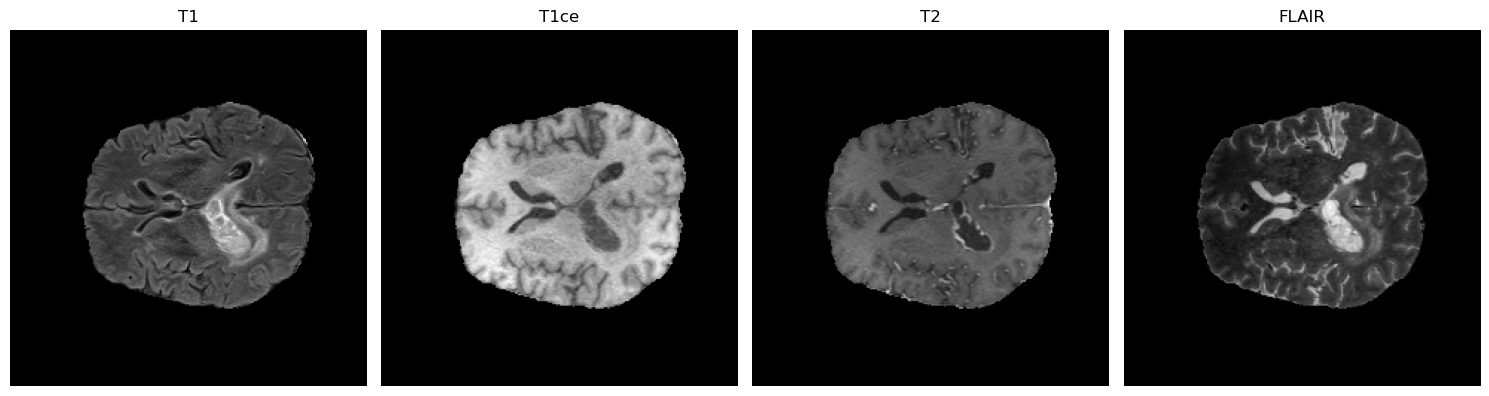

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the NIfTI file
file_path = "/data/hjlee/orhun/data/BRATS18/BRATS18_Preprocessed/Training/Images/Brats18_CBICA_ALX_1.nii.gz"
img = nib.load(file_path)
data = img.get_fdata()

# Function to normalize image to 0-1 range for better visualization
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val != 0:
        return (image - min_val) / (max_val - min_val)
    return image

# Create a function to display slices
def display_slice(data, slice_num=77, modality=0):
    """
    Display a 2D slice from the 3D volume
    Args:
        data: 4D numpy array (240, 240, 155, 4)
        slice_num: The slice number in the z-axis (default: middle slice)
        modality: The modality index (0-3) where:
                 0: T1
                 1: T1ce
                 2: T2
                 3: FLAIR
    """
    # Extract the slice for the specified modality
    slice_data = data[:, :, slice_num, modality]
    
    # Normalize the data for better visualization
    slice_data_normalized = normalize_image(slice_data)
    
    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data_normalized, cmap='gray')
    plt.title(f'Slice {slice_num}, Modality {modality}')
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Display middle slice for each modality
modality_names = ['T1', 'T1ce', 'T2', 'FLAIR']
middle_slice = data.shape[2] // 2  # Get the middle slice

# Display all modalities
plt.figure(figsize=(15, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    slice_data = data[:, :, middle_slice, i]
    slice_data_normalized = normalize_image(slice_data)
    plt.imshow(slice_data_normalized, cmap='gray')
    plt.title(modality_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipykernel_419124/248807014.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


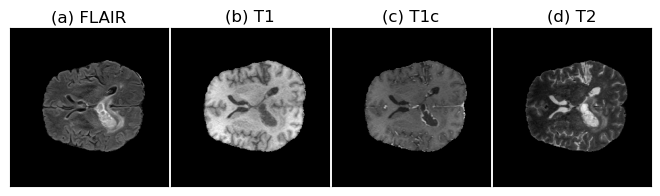

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the NIfTI file
file_path = "/data/hjlee/orhun/data/BRATS18/BRATS18_Preprocessed/Training/Images/Brats18_CBICA_ALX_1.nii.gz"
img = nib.load(file_path)
data = img.get_fdata()

def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val != 0:
        return (image - min_val) / (max_val - min_val)
    return image

# A4 width in inches (210mm = 8.27 inches)
A4_WIDTH = 8.27
A4_HEIGHT = 11.69  # A4 height in inches (297mm = 11.69 inches)

# Create the figure with A4 proportions
fig = plt.figure(figsize=(A4_WIDTH, A4_WIDTH/4))  # Height will be 1/4 of A4 width for the row of images

modality_names = ["FLAIR", "T1", "T1c", "T2"]
middle_slice = data.shape[2] // 2

# Create subplots with minimal spacing
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0.02)

for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    slice_data = data[:, :, middle_slice, i]
    slice_data_normalized = normalize_image(slice_data)
    
    # Display the image
    im = ax.imshow(slice_data_normalized, cmap='gray')
    
    # Add subplot label (a, b, c, d)
    ax.set_title(f'({chr(97+i)}) {modality_names[i]}', pad=5)
    
    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
# Adjust layout to be compact
plt.tight_layout()

# Save in different formats suitable for LaTeX
# High-resolution PDF (vector format, preferred for LaTeX)
plt.savefig('/mnt/disk1/hjlee/orhun/repo/thesis/thesis_plots/brain_modalities.pdf', bbox_inches='tight', dpi=300, format='pdf')
